# Cryptonians #
_**Project Group 2**_

---
## Contents

1. [Data](#Data)
  1. [Load](#Load)
  2. [Explore](#Explore)
  3. [Transformation](#Transformation)
2. [Training](#Training)
3. [Summary](#Summary)

## Data
Place holder for description



### Load
Place holder for description

In [2]:
import boto3
import botocore
import sagemaker
import sys
import pandas as pd
import io
from datetime import datetime
import numpy as np

# Before, we figure out S3 access, we might need to change to our own S3 and prefix.
bucket = '95852-ads-project-team2-s3'
prefix = 'daily'
# @David, please change prefix to 'minute' to save your data
# prefix = 'minute'
filename = 'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27-orig.csv'

############################## KEYS ############################
# @All, please use the accessKeys.csv sent in the email to fill the keys, make sure we don't publish note book with keys to Github.
# AWS will remove key sets from account.
access_key_id='INSERT_HERE'
secret_access_key='INSERT_HERE'
################################################################

execution_role = sagemaker.get_execution_role()

# check if the bucket exists
try:
    s3 = boto3.client(
        's3',
        aws_access_key_id = access_key_id,
        aws_secret_access_key= secret_access_key,
    )
    s3.head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Hey! You don't have permission to access the bucket, 95852-ads-project-team2-s3.


In [5]:
# Step 1: get the bitcoin minute-by-minute data from kaggle (one way or another)
# https://www.kaggle.com/mczielinski/bitcoin-historical-data
# https://www.kaggle.com/mczielinski/bitcoin-historical-data#bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv
    
#import pandas as pd
#!pip install kaggle
#!kaggle datasets download -d mczielinski/bitcoin-historical-data
#!mkdir bitcoin-historical-data
#!mv bitcoin-historical-data.zip /bitcoin-historical-data
#!unzip -a /bitcoin-historical-data/bitcoin-historical-data.zip
#df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

# Either run the lines above this comment or do something like the lines below.

# I saved and unzipped the file to my instance via the above lines, but ran into some difficulty reading it. 
# I tried messing with the path a bit, and then gave up and just read the data from my own S3 bucket

s3 = boto3.client(
    's3',
    aws_access_key_id = access_key_id,
    aws_secret_access_key= secret_access_key,
)
abs_filename = '~/SageMaker/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv'

# the data set is split into 3 csv files, change encoding to properly read
#obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/{filename}')
df = pd.read_csv(abs_filename, encoding="ISO-8859-1", low_memory=False)


### Explore
Place holder for description

In [12]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date,Hour,Minute,...,Low_delta_30,Close_delta_30,Volume_(BTC)_delta_30,Weighted_Price_delta_30,Open_delta_60,High_delta_60,Low_delta_60,Close_delta_60,Volume_(BTC)_delta_60,Weighted_Price_delta_60
60,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 08:00:00,2011-12-31 08:52:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 08:00:00,2011-12-31 08:53:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 08:00:00,2011-12-31 08:54:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 08:00:00,2011-12-31 08:55:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31,2011-12-31 08:00:00,2011-12-31 08:56:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transformation
Place holder for description



#### Remove Missing Value

In [9]:
# Remove NA
df = df.dropna(how='any')

#### Date time feature generation

In [10]:
# Step 2: Add day and hour data elements to the dataframe so we can group by days and hours in later analysis


# create various date formats for grouping later on
df['Time'] = pd.to_datetime(df['Timestamp'], unit = 's', infer_datetime_format = 'True')
df['Date'] = df['Time'].values.astype('datetime64[D]')
df['Hour'] = df['Time'].values.astype('datetime64[h]')
df['Minute'] = df['Time'].values.astype('datetime64[m]')

df = df.drop(columns=['Time', 'Timestamp'])

# reality check - make sure the dataframe looks right so far.
df.head()

KeyError: 'Timestamp'

In [5]:
#create features based on the percentage difference between minute-level values and the corresponding values in the precending minute,
#30 minutes prior and 60 minutes prior.

df[['Open_delta_1', 'High_delta_1', 'Low_delta_1', 'Close_delta_1', 'Volume_(BTC)_delta_1', 'Weighted_Price_delta_1']] = df[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].pct_change(periods = 1)
df[['Open_delta_30', 'High_delta_30', 'Low_delta_30', 'Close_delta_30', 'Volume_(BTC)_delta_30', 'Weighted_Price_delta_30']] = df[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].pct_change(periods = 30)
df[['Open_delta_60', 'High_delta_60', 'Low_delta_60', 'Close_delta_60', 'Volume_(BTC)_delta_60', 'Weighted_Price_delta_60']] = df[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].pct_change(periods = 60)

In [13]:
#removes the columns that were used for form the percentage delta features from  df_deltas
#this data will be used again beginning with step 16

df_deltas = df[df.columns.difference(["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)", "Weighted_Price"])]


In [42]:
# Step 3: Show some charts
import matplotlib.pyplot as plt
# plot the minute-by-minute data
plt.subplot(221)
df['Volume_(BTC)'].plot(legend=True)
plt.title('Trading Volume, by minute')

plt.subplot(222)
df['Close'].plot( legend=True)
plt.title('Closing Price, by minute')

plt.subplot(223)
df['High'].plot(legend=True)
plt.title('High Price, by minute')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


<Figure size 640x480 with 3 Axes>

#### Aggregate by date

In [6]:
# Step 4: group minute-by-minute data points by day to view the standard deviation of the features in the array below
# df_transform = df.groupby(['Date'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price'].agg(['min', 'max', 'std','mean'])
df_daily = df.groupby(['Date'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price'].agg(['min', 'max', 'std','mean'])
# removing '2018-06-27' because I know these values contain NA values and can't be used for training data.
#df_daily = df_daily[df_daily.index != '2018-06-27']

# renaming columns
df_daily.columns = ['Open_min','Open_max','Open_std','Open_mean',\
                      'High_min','High_max','High_std','High_mean', \
                      'Low_min','Low_max','Low_std','Low_mean',\
                      'Close_min','Close_max','Close_std','Close_mean',\
                      'Vol_BTC_min','Vol_BTC_max','Vol_BTC_std','Vol_BTC_mean',\
                      'Vol_Currency_min','Vol_Currency_max','Vol_Currency_std','Vol_Currency_mean',\
                      'Wt_Price_min','Wt_Price_max','Wt_Price_std','Wt_Price_mean']

# only 2,367 data elements in this dataframe
print(df_daily.shape)
# df_daily.head()
df_daily.describe()

(2368, 28)


,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_BTC_std,Vol_BTC_mean,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean
count,2368.000000,2368.000000,2367.000000,2368.000000,2368.000000,2368.000000,2367.000000,2368.000000,2368.000000,2368.000000,...,2367.000000,2368.000000,2368.000000,2.368000e+03,2367.000000,2368.000000,2368.000000,2368.000000,2367.000000,2368.000000
mean,1471.343674,1594.217373,28.754174,1536.670359,1474.282580,1595.604607,28.642632,1538.075386,1469.201182,1592.239130,...,26.644910,11.042641,87.386706,4.341289e+05,29111.856419,15384.776937,1471.422947,1594.088667,28.770256,1536.556323
std,2881.854383,3175.707727,81.676950,3036.796252,2888.516571,3178.478143,81.325773,3040.268635,2878.396098,3170.709672,...,21.056891,8.887354,2944.878656,7.675410e+05,55177.050092,37228.936359,2882.112070,3175.228283,81.685035,3036.514866
min,3.800000,4.380000,0.000000,4.328903,3.800000,4.380000,0.000000,4.328903,1.500000,4.380000,...,0.236352,0.333540,0.000000,6.000000e+00,1.704544,2.057071,3.800000,4.380000,0.000000,4.328903
25%,118.295000,125.130000,0.834915,122.838089,118.407500,125.130000,0.831698,122.890481,117.760000,125.112500,...,13.708088,5.373613,0.491707,4.748237e+04,3017.089388,991.506395,118.095957,125.112804,0.838932,122.833814
50%,408.295000,422.370000,2.899077,416.363757,409.135000,422.400000,2.902781,416.494396,407.235000,422.370000,...,20.743492,8.560639,2.579456,1.401348e+05,8548.530553,2659.305155,408.774454,422.370000,2.930358,416.375524
75%,786.032500,830.175000,11.758791,811.115167,787.732500,830.350000,11.639957,811.613557,785.000000,829.640000,...,33.600570,13.988587,5.012679,3.890178e+05,21786.753492,7771.478061,785.717857,830.036817,11.762217,811.119846
max,18492.000000,19665.760000,836.715679,19189.771083,18621.810000,19666.000000,827.634032,19204.559312,18465.000000,19649.960000,...,341.879912,104.504766,142706.803850,5.483271e+06,505925.178970,536217.694927,18495.292527,19663.298888,835.459423,19186.169610


#### Log Transform
not needed

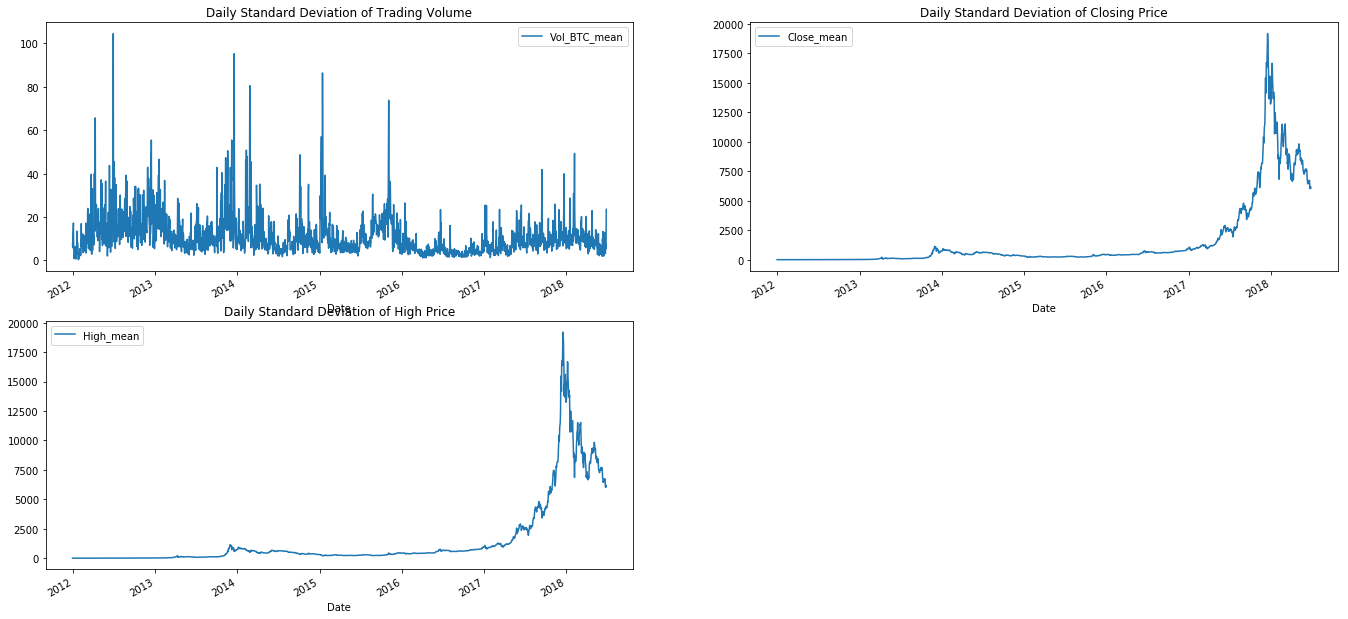

In [32]:
# Step 5: same charts, but using the standard deviation data when minute-level daata is grouped by day
# plotting the daily volatility measures
plt.subplot(221)
df_daily['Vol_BTC_mean'].plot(legend=True)
plt.title('Daily Standard Deviation of Trading Volume')

plt.subplot(222)
df_daily['Close_mean'].plot(legend=True)
plt.title('Daily Standard Deviation of Closing Price')

plt.subplot(223)
df_daily['High_mean'].plot(legend=True)
plt.title('Daily Standard Deviation of High Price')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


In [9]:
# # Step 6: same charts, but using the standard deviation data when minute-level data is grouped by hour

# #df_std_hourly = df.groupby(['Hour']).std()
# df_std_hourly = df.groupby(['Hour'])['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price'].std()
# #df_std_hourly = df_std_hourly[df_std_hourly.index > '2012-06-20']  # standard deviations are all zero before this date

# # plots
# plt.subplot(221)
# df_std_hourly['Volume_(BTC)'].plot(legend=True)
# plt.title('Hourly Standard Deviation of Trading Volume')

# plt.subplot(222)
# df_std_hourly['Close'].plot(legend=True)
# plt.title('Hourly Standard Deviation of Closing Price')

# plt.subplot(223)
# df_std_hourly['High'].plot(legend=True)
# plt.title('Hourly Standard Deviation of High Price')

# plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

# plt.show()

### Training
Place holder for description

In [35]:

df_daily = df_daily.dropna(how='any')
df_daily.isnull().any().any()

False

In [39]:
# Step 7: create the random cut forest object, defining two parameters: num_samples_per_tree and num_trees.
# This will generate a model using the daily standard deviation dataframe

# I don't have the ability to write to Scott's S3 bucket, so I am writing to my own for now.

from sagemaker import RandomCutForest

session = sagemaker.Session()
#bucket = 'ads-bucket-senichol'
#prefix = 'kaggle-crypto-data'
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=100,
                      num_trees=100)
# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(df_daily.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-10-06-20-36-45-621


2018-10-06 20:36:45 Starting - Starting the training job...
Launching requested ML instances......
2018-10-06 20:38:12 Downloading - Downloading input data...
2018-10-06 20:38:20 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[10/06/2018 20:38:50 INFO 140157477230400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[10/06/2018 20:38:50 INFO 140157477230400] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'28', u'num_samples_per_tree': u'100', u'num_trees': u'100'}
[10/06/2


2018-10-06 20:38:53 Uploading - Uploading generated training model
2018-10-06 20:38:59 Completed - Training job completed
Billable seconds: 47


It takes a few minutes for the training instance to become available.

Don't worry about the output text above turning red. That's not an indication of an error.

You can view the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below.
https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs

If you see the message 

> `Billable seconds: nn`

at the end of the output in the box above, that means training successfully completed and the output RCF model was stored in the specified output path.

Building the model with the daily standard deviation data took about 5 minutes and 60 billable seconds.

In [ ]:
# Step 8: another reality check, confirming the name of the new training job. Not very helpful, atcually.
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

In [40]:
# Step 9:  spin up endpoint instances for generating anamaly scores. 
# At this point, we're just starting the endpoint machines, which takes some time.

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-10-06-20-40-06-814
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-10-06-20-36-45-621


--------------------------------------------------------------!

Building the endpoint also takes some time. 5 or 10 minutes.

You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below.  (https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints)

In [41]:
# Step 10: getting ready to send data to the endpoint so that it will spit out anomaly scores

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [42]:
# Step 11: Here we take the original data and reformat it according to the format we just specified in step 10.
df_daily_numpy = df_daily.as_matrix()

In [43]:
# Step 12: We generated anomaly scores for the daily std_dev records. let's look at them.

results = rcf_inference.predict(df_daily_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to daily std_dev dataframe and print first few values
df_daily['score'] = pd.Series(scores, index=df_daily.index)
df_daily['date'] = df_daily.index
df_daily.head()

,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,4.39,4.58,0.094181,4.472552,4.39,4.58,0.094229,4.472624,4.39,4.58,...,2.00000,210.720000,52.694724,34.069690,4.39,4.580000,0.094193,4.472579,1.867878,2011-12-31
2012-01-01,4.58,5.00,0.139856,4.680778,4.58,5.00,0.139856,4.680778,4.58,5.00,...,6.87916,50.500000,19.802958,27.856539,4.58,5.000000,0.139856,4.680778,1.897217,2012-01-01
2012-01-02,5.00,5.00,0.000000,5.000000,5.00,5.00,0.000000,5.000000,5.00,5.00,...,50.50000,95.240000,16.567370,57.832389,5.00,5.000000,0.000000,5.000000,1.926205,2012-01-02
2012-01-03,5.00,5.32,0.145733,5.145917,5.00,5.32,0.145733,5.145917,5.00,5.32,...,0.10280,155.010000,46.211054,68.725391,5.00,5.320000,0.145733,5.145917,1.878219,2012-01-03
2012-01-04,4.93,5.37,0.189487,5.176708,4.93,5.57,0.252133,5.228729,4.93,5.37,...,0.99000,235.747069,85.932931,91.624089,4.93,5.442972,0.210158,5.195443,1.867563,2012-01-04


In [45]:
df_daily.columns

Index(['Open_min', 'Open_max', 'Open_std', 'Open_mean', 'High_min', 'High_max',
       'High_std', 'High_mean', 'Low_min', 'Low_max', 'Low_std', 'Low_mean',
       'Close_min', 'Close_max', 'Close_std', 'Close_mean', 'Vol_BTC_min',
       'Vol_BTC_max', 'Vol_BTC_std', 'Vol_BTC_mean', 'Vol_Currency_min',
       'Vol_Currency_max', 'Vol_Currency_std', 'Vol_Currency_mean',
       'Wt_Price_min', 'Wt_Price_max', 'Wt_Price_std', 'Wt_Price_mean',
       'score', 'date'],
      dtype='object')

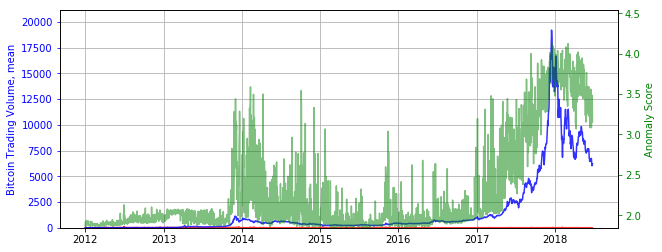

In [48]:
# Step 13: Plot the anomaly scores along with some features from the daily std_dev data

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_daily['Vol_BTC_mean'], color='r', alpha=0.8)
ax1.plot(df_daily['High_mean'], color='b', alpha=0.8)
ax2.plot(df_daily['score'], color='g', alpha=0.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, mean', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.1*df_daily['High_mean'].max())
ax2.set_ylim(df_daily['score'].min(), 1.1*df_daily['score'].max())
fig.set_figwidth(10)


In [54]:
# Step 14: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_daily['score'].mean()
score_std = df_daily['score'].std()
score_cutoff = score_mean + 2*score_std
print("Score mean:" + str(score_mean) + ", Score std: " + str(score_std) + "Score cutoff:" + str(score_cutoff))
anomalies = df_daily[df_daily['score'] > score_cutoff]
print("At a 3 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.head()

Score mean:2.277969515185386, Score std: 0.5899751252922578Score cutoff:3.4579197657699017
At a 3 sd threshhold, there are 209 anomalies.


,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-10,535.30,709.90,24.851997,673.042396,535.31,713.00,24.078926,674.580819,530.00,703.47,...,5.250774,1.865889e+06,94768.151304,32476.952005,533.932106,708.953440,24.802235,673.132713,3.588830,2014-02-10
2014-02-24,520.00,614.84,17.260934,568.126479,534.00,629.00,17.147607,568.881576,514.02,611.52,...,2.764945,1.659301e+06,69139.908124,20481.230439,522.883099,618.654581,17.318245,567.900690,3.497525,2014-02-24
2014-04-10,357.57,442.46,17.718233,408.493917,360.00,442.46,17.407173,409.333083,357.57,442.46,...,0.999998,1.666193e+06,62229.951461,14026.139859,358.124877,442.460000,17.695231,408.518630,3.500584,2014-04-10
2014-10-05,277.97,338.90,14.449493,315.704250,278.17,339.43,14.304777,316.283924,275.00,338.70,...,5.492846,1.761476e+06,54618.684666,13290.427019,276.258759,339.005264,14.555745,315.678048,3.544206,2014-10-05
2017-03-10,983.00,1329.66,49.346348,1202.469681,1009.92,1350.00,48.877499,1203.985424,975.00,1312.03,...,4.186206,1.605414e+06,97519.963849,27271.946827,993.412590,1338.026120,49.640416,1202.407481,3.478415,2017-03-10


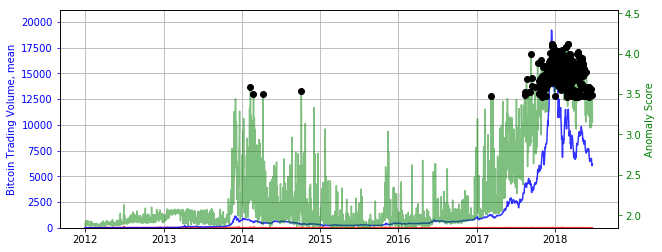

In [55]:
# Step 15: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
# high anomaly scores are highly concentrated around the end of 2017/beginning of 2018.

In [56]:
top_anomaly = df_daily.sort_values('score', ascending=False).head(200)

In [57]:
top_anomaly

,Open_min,Open_max,Open_std,Open_mean,High_min,High_max,High_std,High_mean,Low_min,Low_max,...,Vol_Currency_min,Vol_Currency_max,Vol_Currency_std,Vol_Currency_mean,Wt_Price_min,Wt_Price_max,Wt_Price_std,Wt_Price_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-04,11058.93,11511.00,115.396440,11241.750625,11073.02,11511.00,116.004319,11247.493493,11054.91,11502.60,...,6.890726,5.483271e+06,182467.217079,53741.193772,11061.171049,11508.370551,115.508496,11241.638407,4.124591,2018-03-04
2017-12-19,16849.16,19113.32,540.639710,18321.422215,16892.97,19160.79,532.882094,18343.253479,16831.26,19088.06,...,1430.137291,5.147926e+06,384996.206451,269205.520407,16859.744036,19098.512406,541.211290,18318.281615,4.124573,2017-12-19
2017-12-24,12499.99,14619.00,497.118479,13656.271667,12540.39,14619.10,493.594238,13685.862340,12488.00,14582.60,...,204.897989,5.067908e+06,280907.872671,173941.960865,12502.754693,14608.972793,496.376097,13652.628406,4.096648,2017-12-24
2017-12-20,15483.23,17939.99,449.340240,16835.575458,15506.09,17950.00,445.802121,16866.888813,15343.04,17878.53,...,10081.540083,4.604198e+06,426352.241509,362048.993478,15399.792289,17936.821622,449.284692,16831.690356,4.089893,2017-12-20
2017-12-22,11200.00,15795.50,836.715679,13762.157528,11250.12,15795.61,827.634032,13810.352764,11159.93,15783.00,...,1046.005684,4.238645e+06,505925.178970,536217.694927,11185.521621,15789.526550,835.459423,13759.479206,4.087220,2017-12-22
2018-02-22,9731.28,10934.99,353.938074,10273.241132,9739.14,10935.00,352.726093,10284.450847,9731.20,10928.19,...,8.419992,4.993127e+06,271967.706906,143129.051151,9731.891168,10932.218046,354.088979,10272.359807,4.083927,2018-02-22
2017-12-28,13500.00,15466.79,417.864802,14249.407201,13559.95,15474.19,414.133784,14277.564465,13500.00,15415.39,...,532.706590,4.671107e+06,247061.542829,162797.623985,13533.138938,15463.203289,416.648271,14246.326809,4.057291,2017-12-28
2018-02-06,5945.95,8150.00,543.497216,6827.444826,5975.06,8150.00,542.610903,6852.238215,5920.72,8130.01,...,3838.313742,4.168012e+06,411253.911206,338544.754197,5949.997212,8142.107457,543.658500,6828.327463,4.042596,2018-02-06
2018-01-14,13099.98,14365.81,319.147457,13680.841847,13144.16,14365.81,318.202472,13695.520521,13072.22,14355.59,...,68.690454,4.620886e+06,175154.176690,71386.674958,13104.659559,14365.706435,320.352922,13679.825228,4.039370,2018-01-14


In [62]:
# Save anomaly result to S3
prefix_result_folder = 'anomaly'
result_filename = 'top_200_daily_anomalies_with_dates.csv'

#top_anomaly.to_csv(result_filename, index=True, header=True)

s3 = boto3.client(
    's3'
 #   aws_access_key_id = access_key_id,
 #   aws_secret_access_key= secret_access_key,
)

# Upload the file to S3
with open(result_filename, 'rb') as data:
    s3.upload_fileobj(data, bucket2, Key=f'{prefix_result_folder}/{result_filename}')

In [61]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-10-06-20-36-45-621


In [12]:
#import sys
#import pandas as pd
#top_anom_df = pd.read_csv('top_anomaly.csv', encoding="ISO-8859-1", low_memory=False)

#minute_df = pd.read_csv('~/SageMaker/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv', encoding="ISO-8859-1", low_memory=False)

top_anom_df.columns

Index(['Open_min', 'Open_max', 'Open_std', 'Open_mean', 'High_min', 'High_max',
       'High_std', 'High_mean', 'Low_min', 'Low_max', 'Low_std', 'Low_mean',
       'Close_min', 'Close_max', 'Close_std', 'Close_mean', 'Vol_BTC_min',
       'Vol_BTC_max', 'Vol_BTC_std', 'Vol_BTC_mean', 'Vol_Currency_min',
       'Vol_Currency_max', 'Vol_Currency_std', 'Vol_Currency_mean',
       'Wt_Price_min', 'Wt_Price_max', 'Wt_Price_std', 'Wt_Price_mean',
       'score'],
      dtype='object')

In [13]:
top_anomaly.to_csv('top_anomaly.csv', index=TRUE, header=True)


NameError: name 'top_anomaly' is not defined

In [14]:
#step 16: data cleaning for percentage deltas model

# removing nas and inf values in the delta features. 
df_deltas.loc[:,['Volume_(BTC)_delta_1', 'Volume_(BTC)_delta_30', 'Volume_(BTC)_delta_60']] = df_deltas.loc[:, ['Volume_(BTC)_delta_1', 'Volume_(BTC)_delta_30', 'Volume_(BTC)_delta_60']].replace(np.inf, np.nan)
df_deltas = df_deltas.dropna(how="any")

# Remove unneeded time attributes
df_daily_deltas = df_deltas[df_deltas.columns.difference(["Minute", "Hour"])]
print(df_daily_deltas.columns)

# Group all emaining delta values by Date
df_daily_deltas = df_daily_deltas.groupby(['Date']).agg(['min', 'max', 'std','mean'])

# renaming columns
df_daily_deltas.columns = [ 'Close_delta_1_min', 'Close_delta_1_max', 'Close_delta_1_std', 'Close_delta_1_mean',
                            'Close_delta_30_min', 'Close_delta_30_max', 'Close_delta_30_std', 'Close_delta_30_mean',
                            'Close_delta_60_min', 'Close_delta_60_max', 'Close_delta_60_std', 'Close_delta_60_mean',
                            'High_delta_1_min', 'High_delta_1_max', 'High_delta_1_std', 'High_delta_1_mean',
                            'High_delta_30_min', 'High_delta_30_max', 'High_delta_30_std', 'High_delta_30_mean',
                            'High_delta_60_min', 'High_delta_60_max', 'High_delta_60_std', 'High_delta_60_mean',
                            'Low_delta_1_min', 'Low_delta_1_max', 'Low_delta_1_std', 'Low_delta_1_mean',
                            'Low_delta_30_min', 'Low_delta_30_max', 'Low_delta_30_std', 'Low_delta_30_mean',
                            'Low_delta_60_min', 'Low_delta_60_max', 'Low_delta_60_std', 'Low_delta_60_mean',
                            'Open_delta_1_min', 'Open_delta_1_max', 'Open_delta_1_std', 'Open_delta_1_mean',
                            'Open_delta_30_min', 'Open_delta_30_max', 'Open_delta_30_std', 'Open_delta_30_mean',
                            'Open_delta_60_min', 'Open_delta_60_max', 'Open_delta_60_std', 'Open_delta_60_mean',
                            'Volume_(BTC)_delta_1_min', 'Volume_(BTC)_delta_1_max', 'Volume_(BTC)_delta_1_std', 'Volume_(BTC)_delta_1_mean',
                            'Volume_(BTC)_delta_30_min', 'Volume_(BTC)_delta_30_max', 'Volume_(BTC)_delta_30_std', 'Volume_(BTC)_delta_30_mean',
                            'Volume_(BTC)_delta_60_min', 'Volume_(BTC)_delta_60_max', 'Volume_(BTC)_delta_60_std', 'Volume_(BTC)_delta_60_mean',
                            'Weighted_Price_delta_1_min', 'Weighted_Price_delta_1_max', 'Weighted_Price_delta_1_std', 'Weighted_Price_delta_1_mean',
                            'Weighted_Price_delta_30_min', 'Weighted_Price_delta_30_max', 'Weighted_Price_delta_30_std', 'Weighted_Price_delta_30_mean',
                            'Weighted_Price_delta_60_min', 'Weighted_Price_delta_60_max', 'Weighted_Price_delta_60_std', 'Weighted_Price_delta_60_mean']

#drop any nas that were created during the groupby operation
df_daily_deltas = df_daily_deltas.dropna(how='any')


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Close_delta_1,Close_delta_30,Close_delta_60,High_delta_1,High_delta_30,High_delta_60,Low_delta_1,Low_delta_30,Low_delta_60,Open_delta_1,Open_delta_30,Open_delta_60,Volume_(BTC)_delta_1,Volume_(BTC)_delta_30,Volume_(BTC)_delta_60,Weighted_Price_delta_1,Weighted_Price_delta_30,Weighted_Price_delta_60
count,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06,3.405668e+06
mean,1.187802e-04,2.212481e-04,3.183242e-04,4.399238e-06,1.068776e-04,2.026296e-04,1.189723e-04,2.223852e-04,3.197421e-04,4.560087e-06,1.072826e-04,2.034633e-04,3.796476e+03,1.456511e+04,7.303055e+03,4.305357e-06,1.076810e-04,2.040166e-04
std,2.104644e-01,2.091991e-01,2.106832e-01,2.145243e-03,9.352747e-03,1.219999e-02,2.104654e-01,2.092040e-01,2.103947e-01,2.215377e-03,9.383729e-03,1.225870e-02,3.443781e+06,7.280886e+06,3.116120e+06,2.093954e-03,9.423848e-03,1.230753e-02
min,-9.974514e-01,-9.974622e-01,-9.974787e-01,-3.153153e-01,-4.630137e-01,-5.882353e-01,-9.974434e-01,-9.974589e-01,-9.974747e-01,-3.153153e-01,-4.652406e-01,-5.882353e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.153153e-01,-4.648610e-01,-5.772547e-01
25%,-2.180330e-05,-1.886792e-03,-2.636325e-03,-1.609014e-05,-1.818613e-03,-2.583490e-03,-1.223743e-06,-1.865995e-03,-2.603875e-03,-2.228010e-05,-1.818820e-03,-2.559264e-03,-4.184528e-01,-7.760366e-01,-7.927711e-01,-7.448722e-05,-1.844637e-03,-2.591132e-03
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.633571e-05,2.189553e-03,3.139158e-03,0.000000e+00,2.042440e-03,3.011558e-03,4.060089e-05,2.238407e-03,3.190247e-03,2.852497e-05,2.108785e-03,3.060478e-03,6.915186e-01,3.428508e+00,3.799077e+00,1.073544e-04,2.145351e-03,3.098043e-03
max,3.883733e+02,3.856667e+02,3.881333e+02,5.868421e-01,1.000000e+00,6.254545e-01,3.883733e+02,3.856667e+02,3.875867e+02,5.868421e-01,1.150000e+00,6.254545e-01,6.026224e+09,9.644426e+09,5.027211e+09,5.868421e-01,9.095808e-01,6.240453e-01


In [22]:
#step 17:  building RCF training job for percentage_deltas model.

from sagemaker import RandomCutForest

session = sagemaker.Session()
#bucket = 'ads-bucket-senichol'
#prefix = 'kaggle-crypto-data'
# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.c5.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=100,
                      num_trees=100)
# automatically upload the training data to S3 and run the training job

rcf.fit(rcf.record_set(df_daily_deltas.values))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-10-07-15-50-31-475


2018-10-07 15:50:31 Starting - Starting the training job...
Launching requested ML instances...
Preparing the instances for training...
2018-10-07 15:51:57 Downloading - Downloading input data...
2018-10-07 15:52:05 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
[10/07/2018 15:52:35 INFO 140705125885760] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[10/07/2018 15:52:35 INFO 140705125885760] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'72', u'num_samples_per_tree': u'


2018-10-07 15:52:40 Uploading - Uploading generated training model
2018-10-07 15:52:45 Completed - Training job completed
Billable seconds: 49


In [23]:
# Step 18:  spin up endpoint instances for generating anamaly scores for percentage deltas model. 
# At this point, we're just starting the endpoint machines, which takes some time.

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-10-07-15-53-26-533
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-10-07-15-50-31-475


---------------------------------------------------------------!

In [24]:
# Step 19: getting ready to send data to the endpoint so that it will spit out anomaly scores

from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [25]:
# convert our deltas dataframe to an appropriate matrix format for predicting
df_daily_deltas_numpy = df_daily_deltas.as_matrix()

results = rcf_inference.predict(df_daily_deltas_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to daily std_dev dataframe and print first few values
df_daily_deltas['score'] = pd.Series(scores, index=df_daily_deltas.index)
df_daily_deltas['date'] = df_daily_deltas.index
df_daily_deltas.head()

,Close_delta_1_min,Close_delta_1_max,Close_delta_1_std,Close_delta_1_mean,Close_delta_30_min,Close_delta_30_max,Close_delta_30_std,Close_delta_30_mean,Close_delta_60_min,Close_delta_60_max,...,Weighted_Price_delta_30_min,Weighted_Price_delta_30_max,Weighted_Price_delta_30_std,Weighted_Price_delta_30_mean,Weighted_Price_delta_60_min,Weighted_Price_delta_60_max,Weighted_Price_delta_60_std,Weighted_Price_delta_60_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,0.000000,0.041002,0.001363,0.000048,0.000000,0.043280,0.007727,0.001430,0.000000,0.043280,...,0.000000,0.043280,0.007685,0.001430,0.000000,0.043280,0.010718,0.002860,0.789919,2011-12-31
2012-01-01,0.000000,0.056769,0.001731,0.000062,0.000000,0.056769,0.009299,0.001871,0.000000,0.056769,...,0.000000,0.056769,0.009299,0.001871,0.000000,0.056769,0.012881,0.003743,0.819373,2012-01-01
2012-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.828844,2012-01-02
2012-01-03,-0.033835,0.064000,0.002279,0.000042,-0.033835,0.064000,0.011557,0.001241,-0.033835,0.064000,...,-0.033835,0.064000,0.011557,0.001241,-0.033835,0.064000,0.014971,0.002461,0.801972,2012-01-03
2012-01-04,-0.068053,0.052738,0.002571,0.000039,-0.068053,0.052738,0.014310,0.001178,-0.068053,0.052738,...,-0.068053,0.052738,0.013401,0.000685,-0.068053,0.052738,0.018977,0.001371,0.795449,2012-01-04


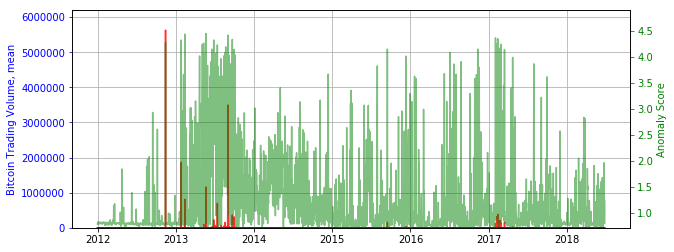

In [28]:
# Step 20: Plot the anomaly scores along with some features from the daily std_dev data

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#https://matplotlib.org/2.0.2/api/colors_api.html

ax1.plot(df_daily_deltas['Volume_(BTC)_delta_60_mean'], color='r', alpha=0.8)
ax1.plot(df_daily_deltas['High_delta_60_mean'], color='b', alpha=0.8)
ax2.plot(df_daily_deltas['score'], color='g', alpha=0.5)

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Bitcoin Trading Volume, mean', color='b')
ax2.set_ylabel('Anomaly Score', color='g')

ax1.tick_params('y', colors='b')
ax2.tick_params('y', colors='g')

ax1.set_ylim(0, 1.1*df_daily_deltas['Volume_(BTC)_delta_60_mean'].max())
ax2.set_ylim(df_daily_deltas['score'].min(), 1.1*df_daily_deltas['score'].max())
fig.set_figwidth(10)
plt.show()

In [29]:
# Step 21: Anomalies are defined as scores greater than 3 standard deviations fronm the mean of score.

score_mean = df_daily_deltas['score'].mean()
score_std = df_daily_deltas['score'].std()
score_cutoff = score_mean + 3*score_std
print("Score mean:" + str(score_mean) + ", Score std: " + str(score_std) + "Score cutoff:" + str(score_cutoff))
anomalies = df_daily_deltas[df_daily_deltas['score'] > score_cutoff]
print("At a 3 sd threshhold, there are " + str(len(anomalies.score)) + " anomalies.")
anomalies.head()

Score mean:1.223711999536373, Score std: 0.7595406510842707Score cutoff:3.502333952789185
At a 3 sd threshhold, there are 91 anomalies.


,Close_delta_1_min,Close_delta_1_max,Close_delta_1_std,Close_delta_1_mean,Close_delta_30_min,Close_delta_30_max,Close_delta_30_std,Close_delta_30_mean,Close_delta_60_min,Close_delta_60_max,...,Weighted_Price_delta_30_min,Weighted_Price_delta_30_max,Weighted_Price_delta_30_std,Weighted_Price_delta_30_mean,Weighted_Price_delta_60_min,Weighted_Price_delta_60_max,Weighted_Price_delta_60_std,Weighted_Price_delta_60_mean,score,date
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-13,-0.010018,0.011080,0.000950,4.505210e-07,-0.009208,0.010223,0.004000,0.000008,-0.011829,0.011040,...,-0.011696,0.010223,0.004203,-0.000201,-0.011696,0.013182,0.005565,-0.000400,4.273640,2012-11-13
2013-01-25,-0.039650,0.041287,0.002695,1.162484e-05,-0.055394,0.024074,0.011472,0.000429,-0.054418,0.027027,...,-0.055394,0.024074,0.011384,0.000428,-0.054418,0.027027,0.014702,0.000848,4.322342,2013-01-25
2013-02-05,-0.014606,0.017327,0.001667,8.195747e-06,-0.021318,0.019724,0.006354,0.000312,-0.017476,0.024777,...,-0.019787,0.020337,0.006238,0.000311,-0.017476,0.024777,0.007076,0.000666,3.662511,2013-02-05
2013-02-12,-0.014806,0.014622,0.001386,4.398210e-05,-0.012100,0.021242,0.005134,0.001091,-0.020511,0.035640,...,-0.012183,0.020416,0.005198,0.001091,-0.020511,0.035640,0.007512,0.002119,4.433848,2013-02-12
2013-04-21,-0.033445,0.051236,0.005937,-2.626094e-05,-0.120760,0.112235,0.023570,-0.001351,-0.144941,0.138891,...,-0.112908,0.110616,0.023465,-0.001336,-0.144822,0.137203,0.032671,-0.002705,4.015459,2013-04-21


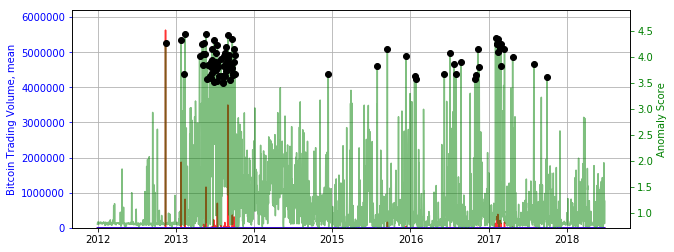

In [30]:
# Step 22: Add the anomalies to the plot.

ax2.plot(anomalies.index, anomalies.score, 'ko')
fig
# high anomaly scores are highly concentrated around the end of 2017/beginning of 2018.

In [31]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-10-07-15-50-31-475


In [49]:
# create an anomaly indicator columns
df_daily_deltas['anomalies'] = (df_daily_deltas['score'] > score_cutoff)
# write dataframe to csv locally
df_daily_deltas.to_csv('df_daily_deltas_with_scores.csv', index=True, header=True)


75

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


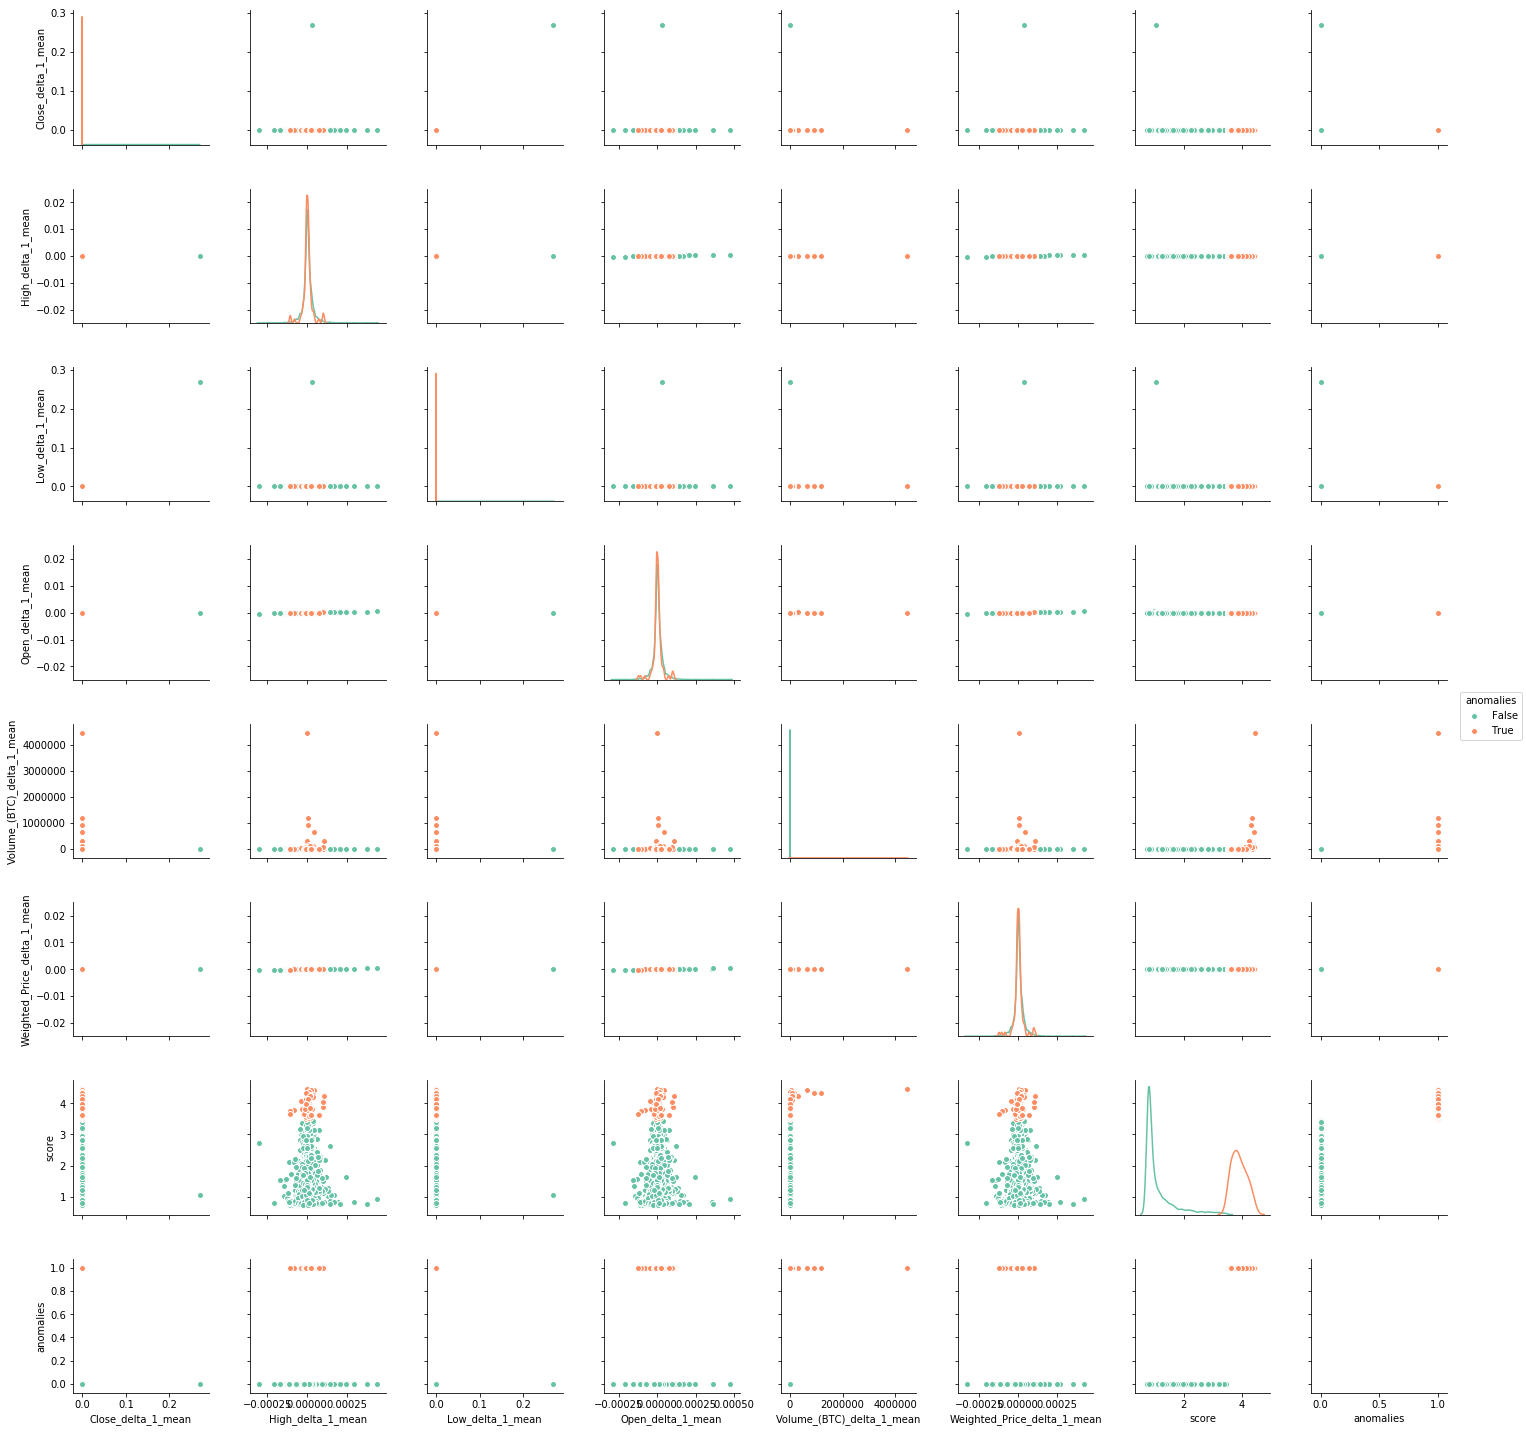

In [67]:
#step 23:  produce a pairwise plot of features. there is a step below that selects a set of feature columns based on a regex search through the column names.
# this can be very slow when including too many features.
import seaborn as sns
from scipy import stats


sixty_cols = df_daily_deltas.columns.str.contains('1_mean', regex=True) # pulls in all attributes with column names matching the pattern in contains()
sixty_cols[72:73] = True # pulls in score attribute
sixty_cols[74:75] = True # pulls in anomaly attribute
sixty_cols
g = sns.pairplot(df_daily_deltas.iloc[:, sixty_cols], hue="anomalies", palette="Set2", diag_kind="kde")
plt.show()

### Summary
Place holder for description